In [1]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.inspection import inspect
from declare_db import Base, Info, Item
from sqlalchemy.orm import sessionmaker
from collections import defaultdict
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
db_name = "exchange.db"
engine_name = 'sqlite:///exchange.db'

def query_to_dict(rset):
    result = defaultdict(list)
    for obj in rset:
        instance = inspect(obj)
        for key, x in instance.attrs.items():
            result[key].append(x.value)
    return result

In [3]:
engine = create_engine(engine_name)
Base.metadata.bind = engine

DBSession = sessionmaker(bind=engine)
session = DBSession()

In [34]:
mats = session.query(Info).join(Item, Info.item_name==Item.info_name).filter(Item.item_type=='Mat').all()

In [7]:
df = pd.DataFrame(query_to_dict(mats)).set_index('id')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

In [9]:
mat_prices = df['price'].groupby(df['item_name']).mean().astype('int64').rename('avg_price')

In [10]:
df = df.join(mat_prices, on='item_name')

In [11]:
df.head(5)

,item_name,timestamp,price,volume,datetime,avg_price
id,,,,,,
21,crystal_mirror,1547025711,131659,19115,2019-01-09 09:21:51,195981
20,crystal_mirror,1547049276,143245,451,2019-01-09 15:54:36,195981
19,crystal_mirror,1547094729,173327,706,2019-01-10 04:32:09,195981
18,crystal_mirror,1547116614,190660,71,2019-01-10 10:36:54,195981
17,crystal_mirror,1547143414,209612,7128,2019-01-10 18:03:34,195981


In [12]:
df['avg_price'].unique()

array([ 195981,  136818,  133118,  192825,  192377,  220699,  242684,
        241255,  104916,  194083,  122211,  185245,  120555,  189981,
         91795,  175741,  209508,  294368,   53584,   32565,    1361,
          2482,  598889, 1255466, 1039675,   12736])

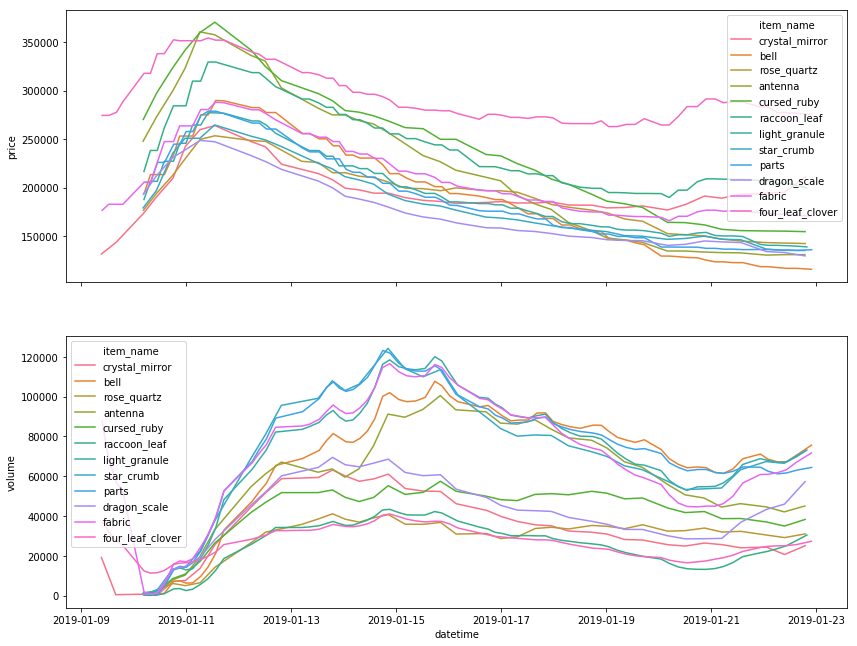

In [15]:
high_mats = df[(df['avg_price'] > 150000) & (df['avg_price'] < 400000) & (df['price'] < 1200000)]
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(14,11))
sns.lineplot(data=high_mats[['item_name', 'price', 'datetime']], x='datetime', y='price', hue='item_name', ax=ax1)
sns.lineplot(data=high_mats[['item_name', 'volume', 'datetime']], x='datetime', y='volume', hue='item_name', ax=ax2)
plt.show()

In [44]:
def process_df(df):
    processed = df.copy()
    processed = processed.set_index('id')
    processed['datetime'] = pd.to_datetime(processed['timestamp'], unit='s')
    avg_prices = processed.groupby(['item_name'])['price'].mean().astype('int64').rename('avg_price')
    processed = processed.join(avg_prices, on='item_name')
    processed['date'] = processed['datetime'].dt.date
    processed = processed.groupby(['item_name', 'date'])['price', 'volume', 'avg_price'].mean().astype('int64')
    return processed

In [51]:
matsdf = pd.DataFrame(query_to_dict(mats))
df = process_df(matsdf).reset_index()

In [74]:
ant = df[df['item_name']=='antenna']
ant.head(5)

,item_name,date,price,volume,avg_price
0,antenna,2019-01-10,285722,4948,220699
1,antenna,2019-01-11,358997,26311,220699
2,antenna,2019-01-12,323112,60951,220699
3,antenna,2019-01-13,278441,62801,220699
4,antenna,2019-01-14,266621,72396,220699


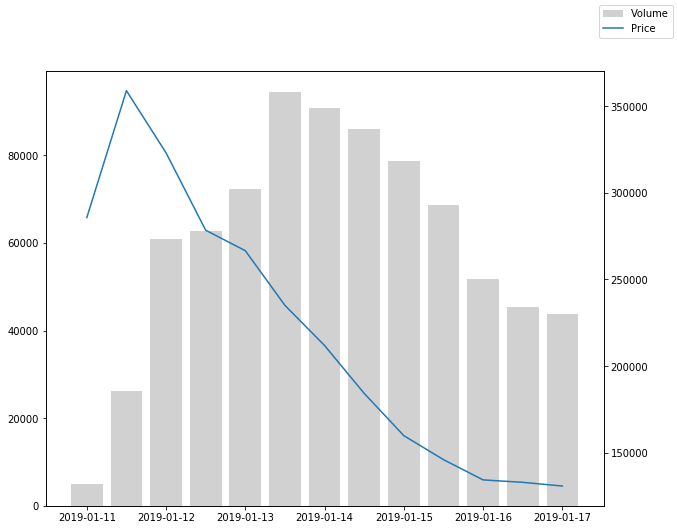

In [79]:
fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()
ax1.bar(ant.index, ant['volume'], color=(190/255,190/255,190/255,0.7), label='Volume')
ax2.plot(ant.index, ant['price'], label='Price')
#plt.xticks(an.index, ant['date'], rotation=90)
ax1.set_xticklabels(ant['date'])
#ax1.legend(loc='best')
#ax2.legend(loc='best')
ax1.figure.legend()
'''
ax2 = 
ax.bar(df_eg.index, df_eg["Release"], color=(190/255,190/255,190/255,0.7), label='Release')
ax2.plot(df_eg.index, df_eg["Hold"], color='green', label='Hold')
ax.set_xticklabels(df_eg.index)
ax.legend(loc='best')
'''
plt.show()